<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/notebook/ch17_GAN_for_image_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


DCGAN Tutorial
==============

- DCGAN 실습은 아래 코드를 smallsize x-ray image data에 적용하도록 한 것으로 자세한 설명은 원본 코드의 주석을 참고합니다.
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Inputs
------

Let’s define some inputs for the run:





In [4]:
dataroot = "data/xray/train" # Root directory for dataset


nz = 100 # Size of z latent vector (i.e. size of generator input)
num_epochs = 40 # Number of training epochs
batch_size = 128 # Batch size during training

image_size = 64 #   size using a transformer.
nc = 1 # Number of channels in the training images. For color images this is 3

ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator

workers = 2 # Number of workers for dataloader



Data
----



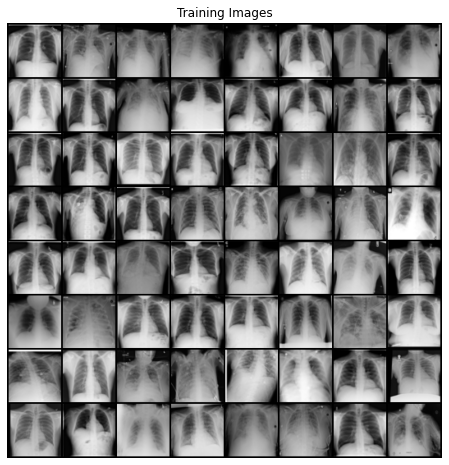

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(),                                                         
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Implementation
--------------

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.



In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [10]:
# Create the generator
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator Code



In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [12]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [23]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.


# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [24]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/40] 	Loss_D: 0.7118	Loss_G: 0.0917	D(x): 0.5734	D(G(z)): 0.0514 / 0.9643
[1/40] 	Loss_D: 0.6592	Loss_G: 5.1552	D(x): 0.6072	D(G(z)): 0.0162 / 0.0496
[2/40] 	Loss_D: 0.7217	Loss_G: 8.9969	D(x): 0.9619	D(G(z)): 0.4059 / 0.0007
[3/40] 	Loss_D: 0.7857	Loss_G: 7.8616	D(x): 0.8921	D(G(z)): 0.4086 / 0.0017
[4/40] 	Loss_D: 0.6892	Loss_G: 6.3654	D(x): 0.9817	D(G(z)): 0.4217 / 0.0054
[5/40] 	Loss_D: 0.4153	Loss_G: 7.3660	D(x): 0.7369	D(G(z)): 0.0066 / 0.0029
[6/40] 	Loss_D: 0.8836	Loss_G: 8.2847	D(x): 0.8925	D(G(z)): 0.4772 / 0.0013
[7/40] 	Loss_D: 0.4412	Loss_G: 5.8221	D(x): 0.9000	D(G(z)): 0.2396 / 0.0087
[8/40] 	Loss_D: 0.5194	Loss_G: 2.5231	D(x): 0.6807	D(G(z)): 0.0354 / 0.1431
[9/40] 	Loss_D: 0.4351	Loss_G: 3.3175	D(x): 0.8158	D(G(z)): 0.1676 / 0.0592
[10/40] 	Loss_D: 0.7431	Loss_G: 5.4606	D(x): 0.9051	D(G(z)): 0.3959 / 0.0079
[11/40] 	Loss_D: 0.3857	Loss_G: 4.6384	D(x): 0.8863	D(G(z)): 0.2007 / 0.0218
[12/40] 	Loss_D: 0.2751	Loss_G: 4.1182	D(x): 0.8429	D(G(z)):

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




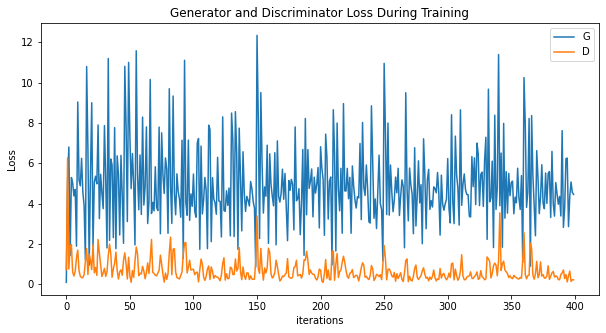

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




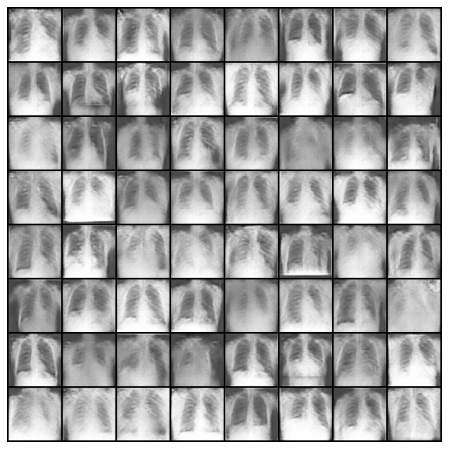

In [26]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




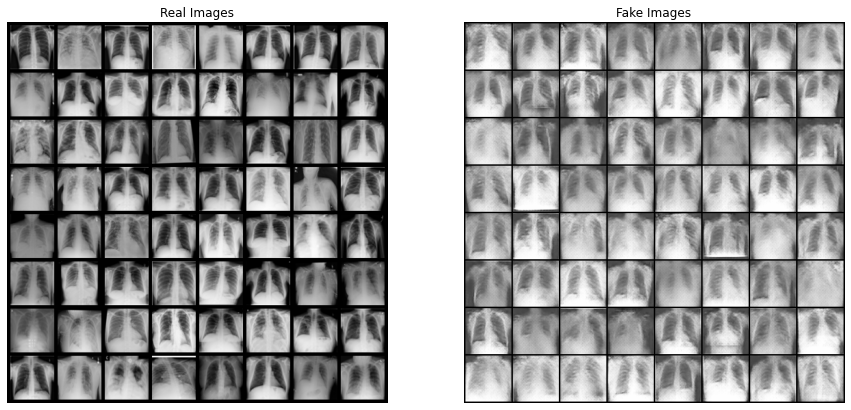

In [27]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

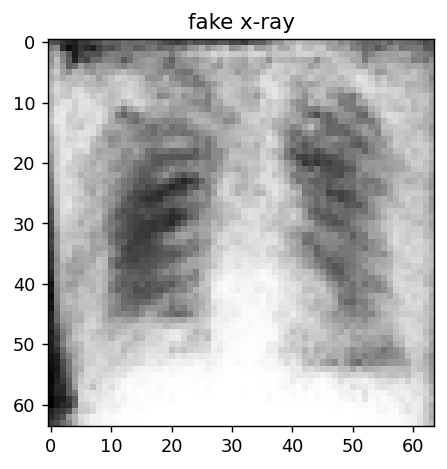

In [36]:
noise = torch.randn(1, nz, 1, 1, device=device)

netG.eval()
with torch.no_grad():
    fake = netG(noise)
    
plt.figure(dpi=128)
plt.imshow(fake[0,0].cpu().detach().numpy(),cmap='gray')
plt.title('fake x-ray')
plt.show()
